The work in this notebook is based on [this discussion post](https://www.kaggle.com/competitions/playground-series-s4e7/discussion/518760) by AmbrosM. I've added 
* Cross-validation
* New features
* New hyperparameters

In [1]:
!pip install -q scikit-learn==1.4 && pip install -q --no-deps scikeras

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, TargetEncoder
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import keras
import gc

2024-07-10 11:46:38.832212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 11:46:38.832457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 11:46:39.010490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
TARGET = 'Response'
N_FOLDS = 5
SEED = 90

N_EPOCHS = 50
LEARNING_RATE = 0.001
BATCH_SIZE = 2048
EVAL_BATCH_SIZE = 65536

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv', index_col='id')

In [5]:
train['is_train'] = 1
test['is_train'] = 0
combined = pd.concat([train, test], axis=0)

In [6]:
# Reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution | Beware of data leakage
combined['Previously_Insured_Annual_Premium'] = pd.factorize(combined['Previously_Insured'].astype(str) + combined['Annual_Premium'].astype(str))[0] 
combined['Previously_Insured_Vehicle_Age'] = pd.factorize(combined['Previously_Insured'].astype(str) + combined['Vehicle_Age'].astype(str))[0]
combined['Previously_Insured_Vehicle_Damage'] = pd.factorize(combined['Previously_Insured'].astype(str) + combined['Vehicle_Damage'].astype(str))[0] 
combined['Previously_Insured_Vintage'] = pd.factorize(combined['Previously_Insured'].astype(str) + combined['Vintage'].astype(str))[0] 

train = combined[combined['is_train'] == 1].drop(columns='is_train')
test = combined[combined['is_train'] == 0].drop(columns=['is_train', TARGET])

del combined

In [7]:
X = train.drop(columns=TARGET)
y = train[TARGET].astype(int)

In [8]:
ohe_columns = [
    'Gender',
    'Region_Code',
    'Vehicle_Age',
    'Vehicle_Damage',
    'Policy_Sales_Channel',
    'Vintage',
    'Previously_Insured_Vehicle_Age',
    'Previously_Insured_Vehicle_Damage'
]
pipeline = make_pipeline(
    ColumnTransformer(
        [
            ('one-hot-encode', OneHotEncoder(drop='first', sparse_output=True, dtype=np.float32, max_categories=200, handle_unknown='ignore'), ohe_columns),
            ('target-encode', make_pipeline(TargetEncoder(), FunctionTransformer(lambda x: x.astype(np.float32)), StandardScaler()), ['Annual_Premium']),
        ],
        remainder=make_pipeline(FunctionTransformer(lambda X: X.astype(np.float32)), StandardScaler(copy=False))
    )
)

X = pipeline.fit_transform(X, y)
X_test = pipeline.transform(test)

del train, test, pipeline
gc.collect()

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


81

In [9]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs            
            score = roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            
            print(f'\n--- Fold {fold_idx + 1} - AUC: {score:.5f}\n\n')
            
            del model
            gc.collect()
            
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        self._save_submission(test_pred_probs, np.mean(scores))
        
        print(f'------ Average AUC:      {np.mean(scores):.5f} ± {np.std(scores):.5f}\n\n')
        
        return oof_pred_probs, scores
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{model_name}_{name}_pred_probs_{cv_score:.5f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)
    
    def _save_submission(self, test_pred_probs, score):
        sub = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
        
        sub['id'] = sub['id']
        sub[TARGET] = test_pred_probs[:, 1]
        
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub.to_csv(f'sub_{name}_{score:.5f}.csv', index=False)

In [10]:
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(1, kernel_initializer='lecun_normal', activation='sigmoid'))
    return model

In [11]:
model = KerasClassifier(
    get_model,
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name='auc')],
    optimizer=keras.optimizers.AdamW(learning_rate=LEARNING_RATE),
    validation_split=0.1,
    batch_size=BATCH_SIZE,
    validation_batch_size=EVAL_BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor='val_auc', patience=3, factor=0.3),
        keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
    ]
)

In [12]:
trainer = Trainer(model)
oof_pred_probs, scores = trainer.fit_predict(X, y, X_test)

Training KerasClassifier

Epoch 1/50
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 183s 44ms/step - auc: 0.8793 - loss: 0.2524 - val_auc: 0.8858 - val_loss: 0.2470 - learning_rate: 0.0010
Epoch 2/50
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 195s 43ms/step - auc: 0.8867 - loss: 0.2465 - val_auc: 0.8877 - val_loss: 0.2459 - learning_rate: 0.0010
Epoch 3/50
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 182s 45ms/step - auc: 0.8872 - loss: 0.2464 - val_auc: 0.8883 - val_loss: 0.2449 - learning_rate: 0.0010
Epoch 4/50
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 181s 44ms/step - auc: 0.8879 - loss: 0.2457 - val_auc: 0.8882 - val_loss: 0.2450 - learning_rate: 0.0010
Epoch 5/50
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 173s 43ms/step - auc: 0.8887 - loss: 0.2452 - val_auc: 0.8889 - val_loss: 0.2444 - learning_rate: 3.0000e-04
Epoch 6/50
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 202s 43ms/step - auc: 0.8890 - loss: 0.2453 - val_auc: 0.8891 - val_loss: 0.2443 - learning_rate: 3.0000e-04
Epoch 7/50
4045/4045 ━━━━━━━━━━━━━━━━━━━━ 173s 42ms/step - auc: 0.8890 - loss: 0.245

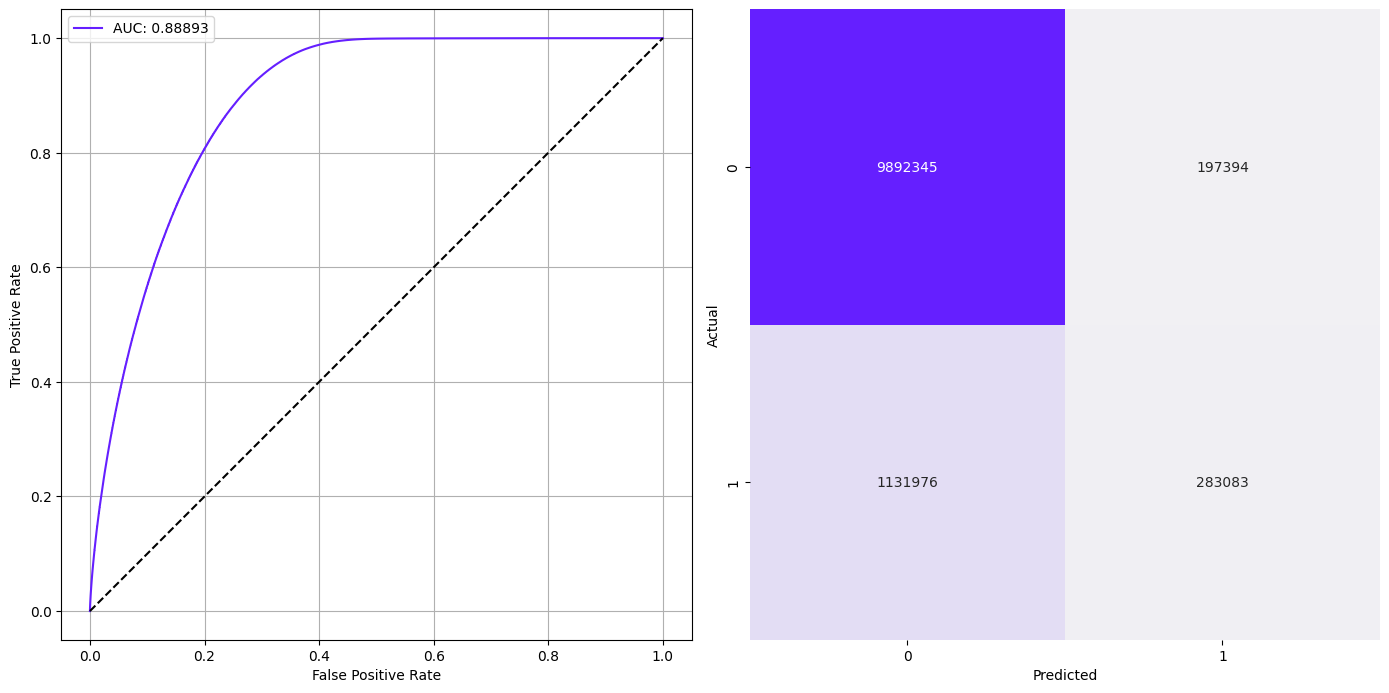

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, _ = roc_curve(y, oof_pred_probs[:, 1])
axes[0].plot(fpr, tpr, label=f'AUC: {np.mean(scores):.5f}', color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

y_pred = oof_pred_probs.argmax(axis=1)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()